# **Lab 7: Convolutional Network Architectures - Brain Tumor MRI Images**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding, Dense, Dropout, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

First we need to load the training and validation datasets, and display the first few rows of each. Displaying the first few rows helps us understand the data structure and content that we will work with. 

The output shows that each row in the datasets includes an identifier, an entity (such as "Borderlands"), a sentiment label (such as "Positive" or "Negative"), and then the tweet text.

In [3]:
# Load Datasets
training_data_path = 'Dataset/twitter_training.csv'
validation_data_path = 'Dataset/twitter_validation.csv'
training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)

# Display First Few Rows For Each Daatset
training_data_head = training_data.head()
validation_data_head = validation_data.head()
(training_data_head, validation_data_head)

(   2401  Borderlands  Positive  \
 0  2401  Borderlands  Positive   
 1  2401  Borderlands  Positive   
 2  2401  Borderlands  Positive   
 3  2401  Borderlands  Positive   
 4  2401  Borderlands  Positive   
 
   im getting on borderlands and i will murder you all ,  
 0  I am coming to the borders and I will kill you...     
 1  im getting on borderlands and i will kill you ...     
 2  im coming on borderlands and i will murder you...     
 3  im getting on borderlands 2 and i will murder ...     
 4  im getting into borderlands and i can murder y...     ,
    3364   Facebook Irrelevant  \
 0   352     Amazon    Neutral   
 1  8312  Microsoft   Negative   
 2  4371      CS-GO   Negative   
 3  4433     Google    Neutral   
 4  6273       FIFA   Negative   
 
   I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy,

Next, we need to check the unique sentiment labels and tweet lengths. We can then calculate some summary statistics for the length of the tweets in the training dataset. 

In [4]:
# Checking Unique Sentiment Labels
training_sentiments_fixed = training_data.iloc[:, 2].unique()
validation_sentiments_fixed = validation_data.iloc[:, 2].unique()

# Adjusting the code to handle NaN or non-string values in tweets
training_tweet_lengths_fixed = training_data.iloc[:, 3].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Recalculating the summary statistics of tweet lengths in the training dataset
tweet_length_summary_fixed = training_tweet_lengths_fixed.describe()

(training_sentiments_fixed, validation_sentiments_fixed, tweet_length_summary_fixed)


(array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object),
 array(['Neutral', 'Negative', 'Positive', 'Irrelevant'], dtype=object),
 count    74681.000000
 mean        19.050120
 std         14.492693
 min          0.000000
 25%          8.000000
 50%         15.000000
 75%         27.000000
 max        198.000000
 Name: im getting on borderlands and i will murder you all ,, dtype: float64)

The output reveals four sentiment categories: Positive, Neutral, Negative, and Irrelevant. It also reveals some statistics about tweet lengths that indicate the distribution of tweet sizes. The tweet length analysis can often help in deciding the sequence length for model input. 

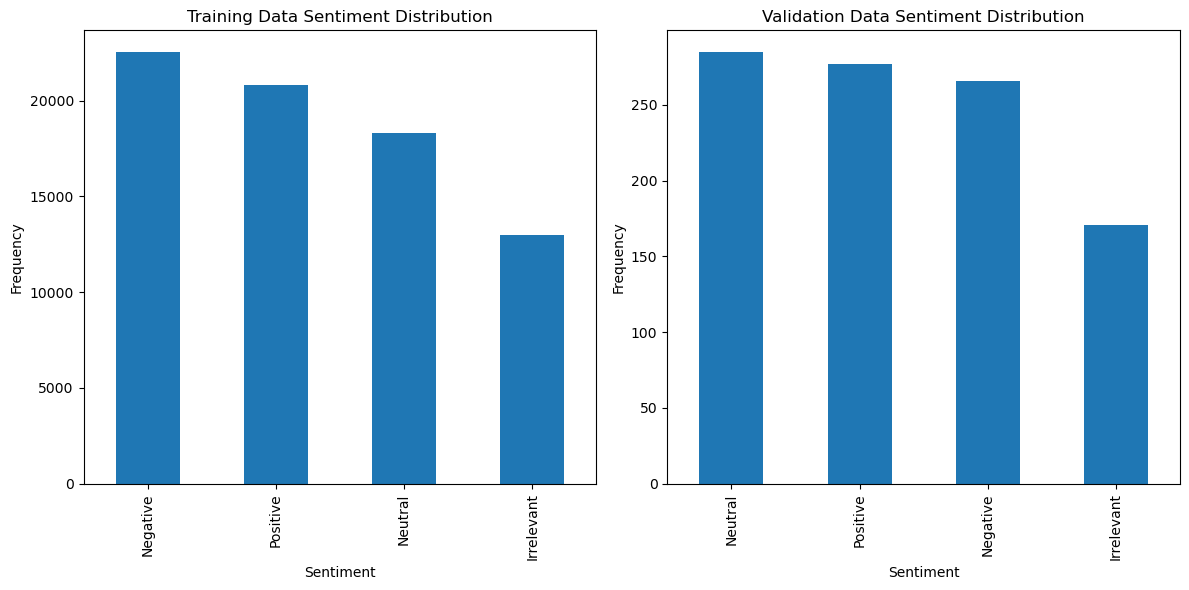

Text(0, 0.5, 'Frequency')

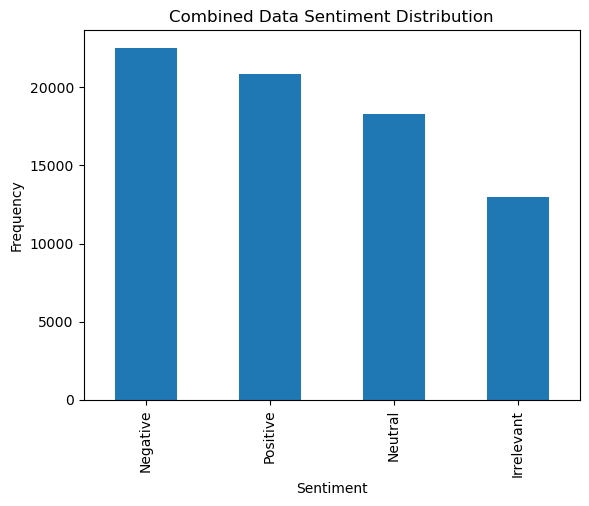

In [9]:
# All Sentiments
all_sentiments = pd.concat([training_data, validation_data]).iloc[:, 2]

# Checking Unique Sentiment Labels
training_sentiments = training_data.iloc[:, 2]
validation_sentiments = validation_data.iloc[:, 2]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
training_sentiments.value_counts().plot(kind='bar')
plt.title('Training Data Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
validation_sentiments.value_counts().plot(kind='bar')
plt.title('Validation Data Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

all_sentiments.value_counts().plot(kind='bar')
plt.title('Combined Data Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

Next, we need to tokenize and pad the training dataset. Tokenization converts the tweet texts to sequences of integers, and the we pad the sequences to a fixed length. 

We also set the following parameters:
- top_words is also set to 5000, meaning the tokenizer will only the top 5000 words. 
- max_sequence_length is set to 50 which determines the length of the input sequences. 



In [15]:
# Parameters
top_words = 5000
max_sequence_length = 50

# Fourth Column Contains Tweet Text
tweet_column_index = 3

# Convert all entries to strings
training_texts = training_data.iloc[:, tweet_column_index].astype(str)
validation_texts = validation_data.iloc[:, tweet_column_index].astype(str)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=top_words, oov_token="<OOV>")
tokenizer.fit_on_texts(training_texts)

# Convert the tweets to sequences
train_sequences = tokenizer.texts_to_sequences(training_texts)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)

# Pad the sequences
X_train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_validation_padded = pad_sequences(validation_sequences, maxlen=max_sequence_length)

In [16]:
# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [18]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the sentiment labels to integers
# Using the third column (index 2) for sentiment labels
y_train = label_encoder.fit_transform(training_data.iloc[:, 2])
y_validation = label_encoder.transform(validation_data.iloc[:, 2])

# Ensure y_train and y_validation are numpy arrays
y_train = np.array(y_train)
y_validation = np.array(y_validation)


In [20]:
# Assuming NUM_CLASSES is the number of sentiment classes
NUM_CLASSES = 4  # Replace with the actual number of sentiment classes

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_sequence_length,))
x = TokenAndPositionEmbedding(max_sequence_length, top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Using softmax for multi-class classification

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

# Compiling the model
model_xformer.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
                      metrics=['accuracy'])

# Training the model
history = model_xformer.fit(
    X_train_padded, y_train, batch_size=64, epochs=2, 
    validation_data=(X_validation_padded, y_validation)
)

2023-12-09 17:40:19.188254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-09 17:40:19.224794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-09 17:40:19.224861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-09 17:40:19.228667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-09 17:40:19.228722: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddi  (None, 50, 32)            161600    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 50, 32)            10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

2023-12-09 17:40:28.095779: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe740024a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-09 17:40:28.095821: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-12-09 17:40:28.106199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-09 17:40:28.428387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-09 17:40:28.517599: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
